# Определение перспективного тарифа для телеком-компании

Клиенты предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Предоставлена выборка из 500 клиентов для анализа, по каждому из них есть отдельные датасеты с использованными ими минутами, трафиком и кол-вом сообщений за года, так же предоставлена подробная информация по каждому тарифу.

Анализ данных будет проведен в несколько этапов:
* Изучение данных
* Предобработка данных
* Анализ данных
* Проверка гипотез
* Общий вывод

## Изучение данных из файлов

In [1]:
import pandas as pd
data_users = pd.read_csv('/datasets/users.csv')
data_users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [2]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В этом датасете не видно особых проблем с данными, единственное, NaN возможно стоит заменить на фразу "Действующий", так как по условиям задачи если в столбце пустые значения значит абонент не перестал пользоваться тарифом.

In [3]:
data_tarrifs = pd.read_csv('/datasets/tariffs.csv')
data_tarrifs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Так же никаких проблем с данными не наблюдается, это всего лишь данные о тарифах. Можно соединить с остальным датасетом по столбцу tariff_name.

In [4]:
data_calls = pd.read_csv('/datasets/calls.csv')
data_calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [5]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В этом датасете собраны все звонки пользователе, пропусков нет, но нужно будет округлить время каждого звонка до минут в большую сторону и добавить в общий дата сет суммарное время по месяцам по каждому пользователю.

In [6]:
data_messages = pd.read_csv('/datasets/messages.csv')
data_messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [7]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Так же данные не являются проблемными, по каждому пользователю нужно посчитать количество сообщений по месяцам и добавить в общий датасет.

In [8]:
data_internet = pd.read_csv('/datasets/internet.csv')
data_internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


In [9]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Так же данные доработки не требуют кроме округления до мегабайт в большую сторону и добавления суммарных данных по месяцам в общий датасет.

## Предобработка данных

Создадим один датасет с оплатами пользователей по месяцам.

В датасете data_calls округлим время в большую сторону, заменим даты на название месяца(данные даны за год, так что он на не нужен), добавим данные по тарифам каждому из пользователей, далее создадим сводную таблицу где по каждому пользователю по месяцам будет показано то сколько минут он использовал, вычтем лимит по тарифу и посчитаем перерасход в рублях.

In [10]:
import math
data_calls['duration'] = data_calls['duration'].apply(math.ceil)
def date_change(row): # создадим фунцию, чтобы заменить даты на месяца.
    if '2018-01' in row:
        return '1'
    if '2018-02' in row:
        return '2'
    if '2018-03' in row:
        return '3'
    if '2018-04' in row:
        return '4'
    if '2018-05' in row:
        return '5'
    if '2018-06' in row:
        return '6'
    if '2018-07' in row:
        return '7'
    if '2018-08' in row:
        return '8'
    if '2018-09' in row:
        return '9'
    if '2018-10' in row:
        return '10'
    if '2018-11' in row:
        return '11'
    if '2018-12' in row:
        return '12'
    
data_calls['call_date'] = data_calls['call_date'].apply(date_change) # меняем дату
tariff = data_users[['user_id', 'tariff']] # создаем отдельный датасет с тарифами пользователей
data_calls = data_calls.merge(tariff, on='user_id') # соеденяем тарифы с датасетом со звонками
data_calls = data_calls.rename(columns={'call_date':'month'}) # меняем название столбца для удобства
data_calls_pivot = data_calls.pivot_table(index=['user_id', 'month'], columns = 'tariff', values='duration', aggfunc='sum') # делаем сводную таблицу
data_calls_pivot['smart_call_payment'] = (data_calls_pivot['smart'] - 500) * 3 # вычитаем лимит из общего числа и умножаем на тариф за перерасход
data_calls_pivot['ultra_call_payment'] = (data_calls_pivot['ultra'] - 3000) * 1
data_calls_pivot[data_calls_pivot < 0] = 0 # значения менее нуля меняем на ноль
data_calls_pivot = data_calls_pivot.rename(columns={'smart':'smart_call_time', 'ultra':'ultra_call_time'}) # меняем название, чтобы с итоговом датасете отличить одни данные от других
data_calls_pivot =  data_calls_pivot.fillna(value=0).reset_index() # Значения NaN заполняем на 0
data_calls_pivot

tariff,user_id,month,smart_call_time,ultra_call_time,smart_call_payment,ultra_call_payment
0,1000,10,0.0,350.0,0.0,0.0
1,1000,11,0.0,338.0,0.0,0.0
2,1000,12,0.0,333.0,0.0,0.0
3,1000,5,0.0,159.0,0.0,0.0
4,1000,6,0.0,172.0,0.0,0.0
...,...,...,...,...,...,...
3169,1498,9,471.0,0.0,0.0,0.0
3170,1499,10,449.0,0.0,0.0,0.0
3171,1499,11,612.0,0.0,336.0,0.0
3172,1499,12,492.0,0.0,0.0,0.0


Тоже самое сделаем с датасетом с трафиком.

In [11]:
import numpy as np
data_internet['session_date'] = data_internet['session_date'].apply(date_change)
data_internet = data_internet.merge(tariff, on='user_id')
data_internet = data_internet.rename(columns={'session_date':'month'})
data_internet_pivot = data_internet.pivot_table(index=['user_id', 'month'], columns = 'tariff', values='mb_used', aggfunc='sum')
data_internet_pivot['smart'] = np.ceil(data_internet_pivot['smart']/1024)
data_internet_pivot['ultra'] = np.ceil(data_internet_pivot['ultra']/1024)
data_internet_pivot['smart_internet_payment'] = (data_internet_pivot['smart'] - 15) * (200)
data_internet_pivot['ultra_internet_payment'] = (data_internet_pivot['ultra'] - 30) * (150)
data_internet_pivot[data_internet_pivot < 0] = 0
data_internet_pivot = data_internet_pivot.rename(columns={'smart':'smart_internet_gb', 'ultra':'ultra_internet_gb'})
data_internet_pivot = data_internet_pivot.fillna(value=0).reset_index()
data_internet_pivot

tariff,user_id,month,smart_internet_gb,ultra_internet_gb,smart_internet_payment,ultra_internet_payment
0,1000,10,0.0,15.0,0.0,0.0
1,1000,11,0.0,15.0,0.0,0.0
2,1000,12,0.0,10.0,0.0,0.0
3,1000,5,0.0,3.0,0.0,0.0
4,1000,6,0.0,23.0,0.0,0.0
...,...,...,...,...,...,...
3198,1498,9,22.0,0.0,1400.0,0.0
3199,1499,10,18.0,0.0,600.0,0.0
3200,1499,11,18.0,0.0,600.0,0.0
3201,1499,12,13.0,0.0,0.0,0.0


Аналогично посчитаем сообщения.

In [12]:
data_messages['message_date'] = data_messages['message_date'].apply(date_change)
data_messages = data_messages.merge(tariff, on='user_id')
data_messages = data_messages.rename(columns={'message_date':'month'})
data_messages_pivot = data_messages.pivot_table(index=['user_id', 'month'], columns = 'tariff', values = 'id', aggfunc='count')
data_messages_pivot['smart_messages_payment'] = (data_messages_pivot['smart'] - 50) * 3
data_messages_pivot['ultra_messages_payment'] = (data_messages_pivot['ultra'] - 1000) * 1
data_messages_pivot[data_messages_pivot < 0] = 0
data_messages_pivot = data_messages_pivot.fillna(value=0).reset_index()
data_messages_pivot = data_messages_pivot.rename(columns={'smart':'smart_messages_amount', 'ultra':'ultra_messages_amount'})
data_messages_pivot

tariff,user_id,month,smart_messages_amount,ultra_messages_amount,smart_messages_payment,ultra_messages_payment
0,1000,10,0.0,73.0,0.0,0.0
1,1000,11,0.0,58.0,0.0,0.0
2,1000,12,0.0,70.0,0.0,0.0
3,1000,5,0.0,22.0,0.0,0.0
4,1000,6,0.0,60.0,0.0,0.0
...,...,...,...,...,...,...
2712,1498,9,44.0,0.0,0.0,0.0
2713,1499,10,48.0,0.0,0.0,0.0
2714,1499,11,59.0,0.0,27.0,0.0
2715,1499,12,66.0,0.0,48.0,0.0


Теперь соединим все три датасета в один и создадим в нем столбец в котором будет находиться сумма с итоговой выручкой с клиента за каждый месяц.

In [13]:
df = pd.merge(data_calls_pivot, data_internet_pivot, on=['user_id', 'month'], how='outer') # соеденим датасеты по очереди
df = pd.merge(df, data_messages_pivot, on=['user_id', 'month'], how='outer')
df = pd.merge(df, data_users, on='user_id')
df['churn_date'] = df['churn_date'].fillna(value='Действующий') # заменим пустые значения на фразу
df = df.fillna(value='0') # заменим все остальняе значения на нули
df['smart_internet_payment'] = df['smart_internet_payment'].astype('float') # сменим тип данных в столбцах
df['smart_call_payment'] = df['smart_call_payment'].astype('float')
df['smart_messages_payment'] = df['smart_messages_payment'].astype('float')
df['ultra_internet_payment'] = df['ultra_internet_payment'].astype('float')
df['ultra_call_payment'] = df['ultra_call_payment'].astype('float')
df['ultra_messages_payment'] = df['ultra_messages_payment'].astype('float')
df['pre_total'] = df['smart_internet_payment'] + df['smart_call_payment'] + df['smart_messages_payment'] + df['ultra_internet_payment'] + df['ultra_call_payment'] + df['ultra_messages_payment']
# создадим столбец с суммой всех пользователей, которые доплатили сверх лимита

def month_payment(row): # создадим фунцию которая добавит помесячную плату
    if 'ultra' in row:
        return 1950
    if 'smart' in row:
        return 550
    
df['paymen_per_month'] = df['tariff'].apply(month_payment) # создадим столбец с помесячной платой
df['total'] = df['pre_total'] + df['paymen_per_month'] # создадим столбец с итговой суммой, которую оплатил каждый пользователь в месяц
df = df.round(decimals=2) # оставим во всех числовых значениях не более двух знаков полсе запятой
df['call_payment'] = df['smart_call_payment'] + df['ultra_call_payment'] # отдельные столбца по каждому тарифу нас уже не понадобятся, поэтому объединим их
df['internet_payment'] = df['smart_internet_payment'] + df['ultra_internet_payment']
df['messages_payment'] = df['smart_messages_payment'] + df['ultra_messages_payment']
df['call_time'] = df['smart_call_time'] + df['ultra_call_time'] # отдельные столбца по каждому тарифу нас уже не понадобятся, поэтому объединим их
df['internet_gb'] = df['smart_internet_gb'] + df['ultra_internet_gb']
df['messages_amount'] = df['smart_messages_amount'] + df['ultra_messages_amount']
df['call_time'] = df['call_time'].astype('int') # сменим тип их данных
df['internet_gb'] = df['internet_gb'].astype('int')
df['messages_amount'] = df['messages_amount'].astype('int')
df = df[['user_id', 'month','tariff', 'call_time', 'internet_gb', 'messages_amount', 'call_payment', 'internet_payment', 'messages_payment', 'pre_total', 'paymen_per_month', 'total', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date']]
# изменим распложение столбцов и уберем лишние
df

,user_id,month,tariff,call_time,internet_gb,messages_amount,call_payment,internet_payment,messages_payment,pre_total,paymen_per_month,total,age,churn_date,city,first_name,last_name,reg_date
0,1000,10,ultra,350,15,73,0.0,0.0,0.0,0.0,1950,1950.0,52,Действующий,Краснодар,Рафаил,Верещагин,2018-05-25
1,1000,11,ultra,338,15,58,0.0,0.0,0.0,0.0,1950,1950.0,52,Действующий,Краснодар,Рафаил,Верещагин,2018-05-25
2,1000,12,ultra,333,10,70,0.0,0.0,0.0,0.0,1950,1950.0,52,Действующий,Краснодар,Рафаил,Верещагин,2018-05-25
3,1000,5,ultra,159,3,22,0.0,0.0,0.0,0.0,1950,1950.0,52,Действующий,Краснодар,Рафаил,Верещагин,2018-05-25
4,1000,6,ultra,172,23,60,0.0,0.0,0.0,0.0,1950,1950.0,52,Действующий,Краснодар,Рафаил,Верещагин,2018-05-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,10,smart,0,20,21,0.0,1000.0,0.0,1000.0,550,1550.0,35,Действующий,Санкт-Петербург,Павел,Гончаров,2018-08-15
3210,1489,11,smart,0,18,20,0.0,600.0,0.0,600.0,550,1150.0,35,Действующий,Санкт-Петербург,Павел,Гончаров,2018-08-15
3211,1489,12,smart,0,17,35,0.0,400.0,0.0,400.0,550,950.0,35,Действующий,Санкт-Петербург,Павел,Гончаров,2018-08-15
3212,1489,8,smart,0,11,17,0.0,0.0,0.0,0.0,550,550.0,35,Действующий,Санкт-Петербург,Павел,Гончаров,2018-08-15


В итоге получен общий датасет с итоговыми суммами.

In [14]:
df[df['user_id']==1138]

,user_id,month,tariff,call_time,internet_gb,messages_amount,call_payment,internet_payment,messages_payment,pre_total,paymen_per_month,total,age,churn_date,city,first_name,last_name,reg_date
855,1138,10,smart,562,27,9,186.0,2400.0,0.0,2586.0,550,3136.0,23,Действующий,Екатеринбург,Леся,Ерофеева,2018-07-13
856,1138,11,smart,526,22,7,78.0,1400.0,0.0,1478.0,550,2028.0,23,Действующий,Екатеринбург,Леся,Ерофеева,2018-07-13
857,1138,12,smart,527,25,8,81.0,2000.0,0.0,2081.0,550,2631.0,23,Действующий,Екатеринбург,Леся,Ерофеева,2018-07-13
858,1138,7,smart,483,16,7,0.0,200.0,0.0,200.0,550,750.0,23,Действующий,Екатеринбург,Леся,Ерофеева,2018-07-13
859,1138,8,smart,859,29,3,1077.0,2800.0,0.0,3877.0,550,4427.0,23,Действующий,Екатеринбург,Леся,Ерофеева,2018-07-13
860,1138,9,smart,701,24,2,603.0,1800.0,0.0,2403.0,550,2953.0,23,Действующий,Екатеринбург,Леся,Ерофеева,2018-07-13


## Анализ данных

Разделим датасет на два для анализа тарифов ultra и smart.

In [15]:
df_ultra = df.query('tariff == "ultra"')
df_smart = df.query('tariff == "smart"')

Теперь построим графики и проанализируем звонки, сообщения и интернет трафик по месяцам. 

### Анализ звонков

Для анализа среднего, дисперсии и среднего отклонения построим графики:

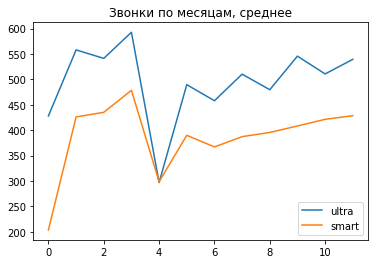

In [16]:
import matplotlib.pyplot as plt
df_ultra_call = df_ultra.pivot_table(index=['month'], values='call_time', aggfunc='mean').reset_index()
df_smart_call = df_smart.pivot_table(index=['month'], values='call_time', aggfunc='mean').reset_index()
plt.plot(df_ultra_call['call_time'], label = 'ultra')
plt.plot(df_smart_call['call_time'], label = 'smart')
plt.legend()
plt.title('Звонки по месяцам, среднее')
plt.show()

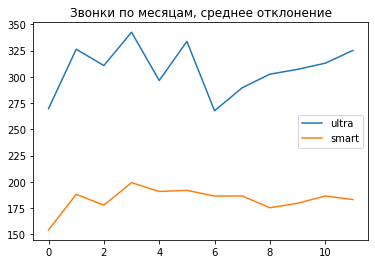

In [17]:
df_ultra_call_std = df_ultra.pivot_table(index=['month'], values='call_time', aggfunc=np.std).reset_index()
df_smart_call_std = df_smart.pivot_table(index=['month'], values='call_time', aggfunc=np.std).reset_index()
plt.plot(df_ultra_call_std['call_time'], label = 'ultra')
plt.plot(df_smart_call_std['call_time'], label = 'smart')
plt.title('Звонки по месяцам, среднее отклонение')
plt.legend()
plt.show()

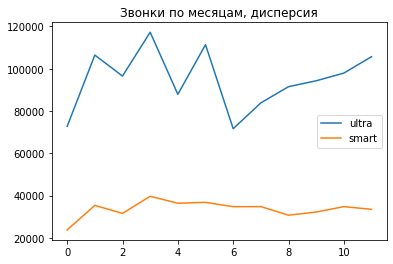

In [18]:
df_ultra_call_var = df_ultra.pivot_table(index=['month'], values='call_time', aggfunc=np.var).reset_index()
df_smart_call_var = df_smart.pivot_table(index=['month'], values='call_time', aggfunc=np.var).reset_index()
plt.plot(df_ultra_call_var['call_time'], label = 'ultra')
plt.plot(df_smart_call_var['call_time'], label = 'smart')
plt.title('Звонки по месяцам, дисперсия')
plt.legend()
plt.show()

Графики показывают, что в среднем абоненты тарифа ultra тратят больше минут на разговоры при этом стандартное отклонение и дисперсия показывают, что разброс данных по пользователям этого тарифа гораздо выше. Скорее всего такое поведение связано с тем что у пользователей ultra минутный пакет в разы больше и они могут его использовать не думаю о превышении лимита. По какой-то причине в апреле идет резкий провал в графике, скорее всего это связано со сбоями связи.

### Анализ трафика

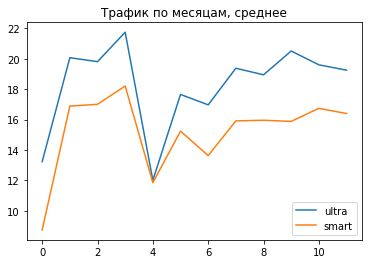

In [19]:
df_ultra_internet = df_ultra.pivot_table(index=['month'], values='internet_gb', aggfunc='mean').reset_index()
df_smart_internet = df_smart.pivot_table(index=['month'], values='internet_gb', aggfunc='mean').reset_index()
plt.plot(df_ultra_internet['internet_gb'], label = 'ultra')
plt.plot(df_smart_internet['internet_gb'], label = 'smart')
plt.legend()
plt.title('Трафик по месяцам, среднее')
plt.show()

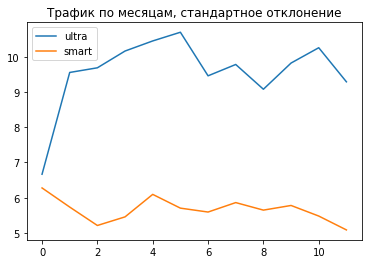

In [20]:
df_ultra_internet_std = df_ultra.pivot_table(index=['month'], values='internet_gb', aggfunc=np.std).reset_index()
df_smart_internet_std = df_smart.pivot_table(index=['month'], values='internet_gb', aggfunc=np.std).reset_index()
plt.plot(df_ultra_internet_std['internet_gb'], label = 'ultra')
plt.plot(df_smart_internet_std['internet_gb'], label = 'smart')
plt.legend()
plt.title('Трафик по месяцам, стандартное отклонение')
plt.show()

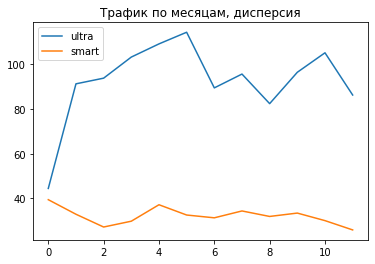

In [21]:
df_ultra_internet_var = df_ultra.pivot_table(index=['month'], values='internet_gb', aggfunc=np.var).reset_index()
df_smart_internet_var = df_smart.pivot_table(index=['month'], values='internet_gb', aggfunc=np.var).reset_index()
plt.plot(df_ultra_internet_var['internet_gb'], label = 'ultra')
plt.plot(df_smart_internet_var['internet_gb'], label = 'smart')
plt.legend()
plt.title('Трафик по месяцам, дисперсия')
plt.show()

Аналогично минутам абоненты тарифа ultra тратят больше, дисперсия и стандартное отклонение гораздо выше у пользователей ultra. Так же в апреле есть резкое падение использование трафика.

### Анализ сообщений

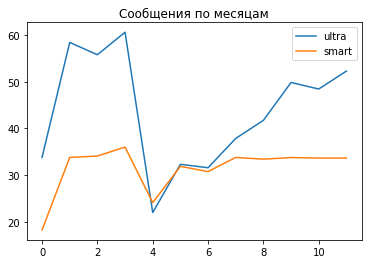

In [22]:
df_ultra_messages = df_ultra.pivot_table(index=['month'], values='messages_amount', aggfunc='mean').reset_index()
df_smart_messages = df_smart.pivot_table(index=['month'], values='messages_amount', aggfunc='mean').reset_index()
plt.plot(df_ultra_messages['messages_amount'], label = 'ultra')
plt.plot(df_smart_messages['messages_amount'], label = 'smart')
plt.legend()
plt.title('Сообщения по месяцам')
plt.show()

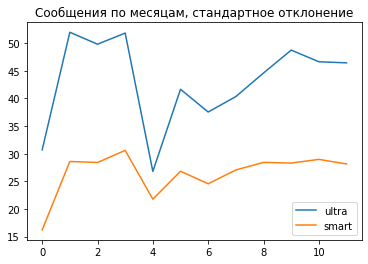

In [23]:
df_ultra_messages_std = df_ultra.pivot_table(index=['month'], values='messages_amount', aggfunc=np.std).reset_index()
df_smart_messages_std = df_smart.pivot_table(index=['month'], values='messages_amount', aggfunc=np.std).reset_index()
plt.plot(df_ultra_messages_std['messages_amount'], label = 'ultra')
plt.plot(df_smart_messages_std['messages_amount'], label = 'smart')
plt.legend()
plt.title('Сообщения по месяцам, стандартное отклонение')
plt.show()

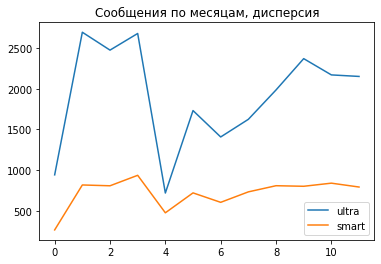

In [24]:
df_ultra_messages_var = df_ultra.pivot_table(index=['month'], values='messages_amount', aggfunc=np.var).reset_index()
df_smart_messages_var = df_smart.pivot_table(index=['month'], values='messages_amount', aggfunc=np.var).reset_index()
plt.plot(df_ultra_messages_var['messages_amount'], label = 'ultra')
plt.plot(df_smart_messages_var['messages_amount'], label = 'smart')
plt.legend()
plt.title('Сообщения по месяцам, дисперсия')
plt.show()

Картина схожа с другими данными, пользователи ultra  отправляют больше сообщений и разброс данных у них выше. Так же наблюдается провал в апреле.

### Анализ количества оказанных усулуг.

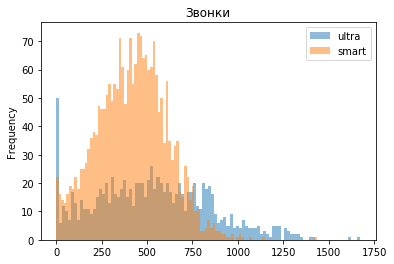

In [25]:
ax = df_ultra['call_time'].plot(bins = 100, kind = 'hist', alpha=0.5, label = 'ultra')
df_smart['call_time'].plot(bins = 100, kind = 'hist', alpha=0.5, label = 'smart', ax=ax)
plt.legend()
plt.title('Звонки')
plt.show()

Большинство абонентов smart тратят минуты в близко к своему лимиту или слегка превысив его, в то время как пользователи ultra его не превышают. Не все пользователи и не всегда пользуются данной услугой. 

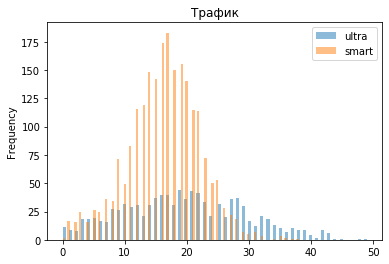

In [26]:
ax = df_ultra['internet_gb'].plot(bins = 100, kind = 'hist', alpha=0.5, label = 'ultra')
df_smart['internet_gb'].plot(bins = 100, kind = 'hist', alpha=0.5, label = 'smart', ax=ax)
plt.legend()
plt.title('Трафик')
plt.show()


Большинство абонентов тарифа smart чаще превышают свой лимит в 15 gb, в то время как большинство абонентов ultra остаются в своем лимите 30 gb.

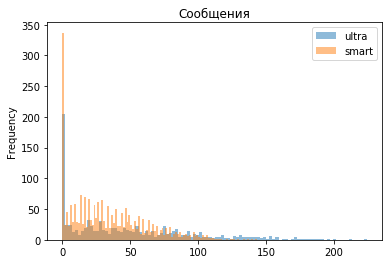

In [27]:
ax = df_ultra['messages_amount'].plot(bins = 100, kind = 'hist', alpha=0.5, label = 'ultra')
df_smart['messages_amount'].plot(bins = 100, kind = 'hist', alpha=0.5, label = 'smart', ax=ax)
plt.legend()
plt.title('Сообщения')
plt.show()

Абоненты обоих тарифов в большинстве тратят не более 50 сообщений в месяц. Так же по графику видно, что клиенты обоих тарифов часто вообще не отправляют сообщения.

**Вывод** 

Из графиков можно сделать выводы, что пользователи тарифа ultra неравномерно используют пакет предложенный им, это связано с большим диапазоном лимита, его они как правило не превышают, в свою очередь пользователи тарифов smart чаще превышают лимиты, так же видно то что в апреле у операторов связи наблюдался провал в использовании услуг. Хотелось бы отметить так же, что сообщениями абоненты пользуются редко.

## Проверка гипотез 

По представленной выборке можно выдвинуть две гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для проверки обеих гипотез создадим по два датасета и выдвинем по нулевой гипотезе, которые будут говорить о равенстве двух выборок, если результат будет меньше 5%, то опровергаем нулевую гипотезу и принимаем альтернативные, которыми являются вышеобозначенные.

### Проверка гипотезы:  средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Создадим выборку с выручкой по тарифам.

In [28]:
df_ultra_for_test = df_ultra['total']
df_smart_for_test = df_smart['total']

Далее введем нулевую гипотезу: выручка пользователей тарифов равны. Проверим данную гипотезу, отбросим в том случае если результат будет меньше 5%. Аргумент equal_var лучше указать как False, так в данном случае исследуются две выборки с тарифами высокой и низкой ценовой категории, соответственно, поведение пользователей может различаться как и дисперсия.

In [29]:
from scipy import stats as st
import numpy as np

alpha = .05
result_first = st.ttest_ind(df_ultra_for_test, df_smart_for_test, equal_var=False)

print('p-значение: ', result_first.pvalue)

if result_first.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


По результату теста отвергаем нулевую гипотезу и принимаем альтернативную, которая гласит, что выручка пользователей двух тарифов отличается.

### Проверка гипотезы: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Создадим выборки в одной из которых будет выручка пользователей из Москвы, а в другой из других регионов.

In [30]:
df_moscow = df.query('city == "Москва"')['total']
df_other = df.query('city != "Москва"')['total']

Далее введем нулевую гипотезу: выручка пользователей разных регионов равны. Проверим данную гипотезу, отбросим в том случае если результат будет меньше 5%. Аргумент equal_var лучше указать как False, так в данном случае исследуются две выборки в которых содержатся данные пользователей из разных городов, соответственно, поведение пользователей может различаться как и дисперсия.

In [31]:
alpha = .05
result_first = st.ttest_ind(df_moscow, df_other, equal_var=False)

print('p-значение: ', result_first.pvalue)

if result_first.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


По реультату теста принимаем нулевую гипотезу, выручка абонентов Москвы и регионов может быть одинаковой.

### Анализ по результатам проверки гипотез

В результате проверки гипотез мы можем предположить, что выручка с пользователей разных тарифов по месяцам различается, посмотрим это на графике:

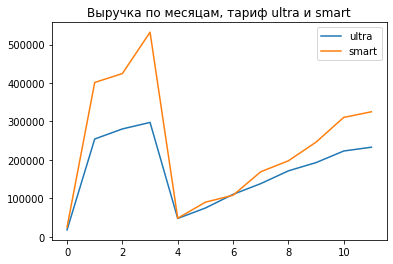

In [32]:
df_ultra_earnings = df_ultra.pivot_table(index='month', values='total', aggfunc='sum').reset_index()
df_smart_earnings = df_smart.pivot_table(index='month', values='total', aggfunc='sum').reset_index()
plt.plot(df_ultra_earnings['total'], label = 'ultra')
plt.plot(df_smart_earnings['total'], label = 'smart')
plt.legend()
plt.title('Выручка по месяцам, тариф ultra и smart')
plt.show()

На графике видно, что пользователи тарифов ultra и smart приносят не одинаковую выручку, видно, что после апреля выручка с пользователей ultra выше, так же видно, что по какой-то причине выручка в апреле упала. 

Построим аналогичный график для пользователей Москвы и регионов:

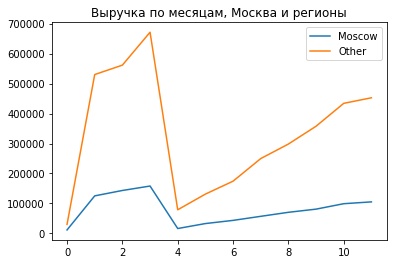

In [33]:
df_moscow_earnings = df.query('city == "Москва"')
df_other_earnings = df.query('city != "Москва"')
df_moscow_earnings = df_moscow_earnings.pivot_table(index='month', values='total', aggfunc= 'sum').reset_index()
df_other_earnings = df_other_earnings.pivot_table(index='month', values='total', aggfunc= 'sum').reset_index()
plt.plot(df_moscow_earnings['total'], label = 'Moscow')
plt.plot(df_other_earnings['total'], label = 'Other')
plt.legend()
plt.title('Выручка по месяцам, Москва и регионы')
plt.show()

На основе выборки можно сказать, что абоненты из Москвы приносят больше выручки чем абоненты из регионов.

## Общий вывод

Из анализа предложенной выборки можно предположить, что абоненты тарифа Ultra приносят выручку больше чем абоненты тарифа Smart, так же абоненты из Москвы могут приносить столько же денег сколько и абоненты регионов. Можно сказать, что пользователи тарифа ultra неравномерно используют пакет предложенный им тарифом, это связано с большим диапазоном лимита, его они как правило не превышают, в то время как пользователи smart чаще превышают лимиты. Хотелось бы отметить так же, что сообщениями абоненты пользуются редко. 

На основе выборки рекомендую:
* увеличить направленность рекламы на продажу тарифа smart;
* выяснить причину провала во всех услугах в апреле, если оно не является сезонным, так как это спровоцировало падение выручки.